<a href="https://colab.research.google.com/github/miatia1025/sim-using-tagger/blob/main/sim_using_tagger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 爆破用

In [ ]:
# @markdown #💣削除用！注意！  
# @markdown 例 : `/content/test`で`/content/test`を中身ごと削除  
import shutil
dir = r"E:\AI\miatiadev\miatia-tagger\imgs\00_similarity" # @param{type:"string"}
shutil.rmtree(dir)

In [ ]:
%cd /content/

# Main

In [1]:
# git lfs initializer
# @markdown <hr>

# @markdown ##Definitions
# @markdown <hr>

# @markdown #🌱Initializer Area

home_dir = r"E:\AI\miatiadev\miatia-tagger"
%cd {home_dir}

import os
where_to_download_img = r"E:\AI\miatiadev\miatia-tagger\imgs\03_tagger" #@param {type:"string"}
if not os.path.exists(where_to_download_img):
    os.makedirs(where_to_download_img)

where_to_download_model = r"E:\AI\miatiadev\miatia-tagger\models" #@param {type:"string"}
if not os.path.exists(where_to_download_model):
    os.makedirs(where_to_download_model)


E:\AI\miatiadev\miatia-tagger


In [2]:
# @markdown <hr>

# @markdown ##downloading area ( IMG )
# @markdown <hr>

# @markdown #⬇️Downloading Area

## for regex
import re

%cd {where_to_download_img}

## Variables
IMG_URLS = '''
https://cdn.discordapp.com/attachments/1049901014238629888/1067410126048337980/00002.png,
https://cdn.discordapp.com/attachments/1049901014238629888/1067410185406124093/00003.png,
https://i.imgur.com/SQtuCgg.png,
https://i.imgur.com/X1Ycefh.png,
https://cdn.discordapp.com/attachments/1049901014238629888/1073615869164388522/17076-7th_7th_anime_3.1_A.png,
https://cdn.discordapp.com/attachments/1049901014238629888/1086588668090785852/03067-_Fav_loliNJVA_loli_G3735941c3cdd8d3344ae8a8a3fc097ee7f4b5236.png,
https://cdn.discordapp.com/attachments/1049901014238629888/1086595489102827530/00960-_Fav_loliDiffusion_loliDiffusionV0.5.3_AOM2_SFW_VAE_PURIFIED.png,
'''

img_urls = IMG_URLS.strip()
img_urls = img_urls.replace(",", "")

url_list = [url.strip() for url in img_urls.split('\n')]

SAVE_AS_CHECK = True # @param {type:"boolean"}
SAVE_AS_FILENAMES = '''
A.png,
B.png,
C.png,
D.jpg,
E.png,
F.jpg,
G.png,
'''

img_filenames = SAVE_AS_FILENAMES.strip()
img_filenames = img_filenames.replace(",", "")

filename_list = [url.strip() for url in img_filenames.split('\n')]

## Download with Gigafile Check
try:
  if SAVE_AS_CHECK:
    assert len(url_list)==len(filename_list)
except AssertionError:
  print("Error: url_list and filename_list have different lengths.")

else:
  for i in range(len(url_list)):
    IMG_URL = url_list[i]

    if SAVE_AS_CHECK:
      SAVE_AS_FILENAME = filename_list[i]
      !curl -o $SAVE_AS_FILENAME $IMG_URL
    else:
      !curl -OJL $IMG_URL

E:\AI\miatiadev\miatia-tagger\imgs\03_tagger


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  108k  100  108k    0     0   297k      0 --:--:-- --:--:-- --:--:--  298k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  304k  100  304k    0     0  1042k      0 --:--:-- --:--:-- --:--:-- 1043k
100  304k  100  304k    0     0  1042k      0 --:--:-- --:--:-- --:--:-- 1043k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 24  963k   24  239k    0     0   235k      0  0:

In [ ]:
# @markdown <hr>

# @markdown ##downloading area ( Model )
# @markdown <hr>

# @markdown #📰Cloning Area

## for regex
import re

%cd {where_to_download_model}

## Variables
MODEL_URLS = "https://huggingface.co/SmilingWolf/wd-v1-4-swinv2-tagger-v2, https://huggingface.co/SmilingWolf/wd-v1-4-convnextv2-tagger-v2" # @param {type:"string"}
model_urls_list = [url.strip() for url in MODEL_URLS.split(',')]

CLONE_AS = True # @param {type:"boolean"}
CLONE_AS_NAME = "swinv2, convnextv2" # @param {type:"string"}
filenames_list = [url.strip() for url in CLONE_AS_NAME.split(',')]

## Download with Gigafile Check
try:
  if CLONE_AS:
    assert len(model_urls_list)==len(filenames_list)
except AssertionError:
  print("Error: MODEL_URLS and CLONE_AS_NAME have different lengths.")
else:
  for i in range(len(model_urls_list)):
    MODEL_URL = model_urls_list[i]

    if CLONE_AS:
      CLONE_AS_NAME = filenames_list[i]
      !git clone $MODEL_URL $CLONE_AS_NAME
    else:
      !git clone $MODEL_URL $CLONE_AS_NAME

ic| embeddings[i]: array([[3.3722609e-01, 6.1302620e-01, 5.5438280e-04, ..., 2.7418137e-06,
                           1.0728836e-06, 1.3113022e-06]], dtype=float32)
ic| embeddings[i].shape[1]: 9083
ic| embedding[0].ndim: 1
ic| embeddings[i]: array([[3.0054879e-01, 6.7262465e-01, 4.0394068e-04, ..., 1.3113022e-06,
                           8.3446503e-07, 1.0728836e-06]], dtype=float32)
ic| embeddings[i].shape[1]: 9083
ic| embedding[0].ndim: 1
ic| embeddings[i]: array([[2.7010322e-02, 9.6838224e-01, 4.0995479e-03, ..., 7.1525574e-07,
                           4.7683716e-07, 5.9604645e-07]], dtype=float32)
ic| embeddings[i].shape[1]: 9083
ic| embedding[0].ndim: 1
ic| embeddings[i]: array([[1.4325535e-01, 8.6056244e-01, 2.5746822e-03, ..., 4.1723251e-06,
                           2.1457672e-06, 2.1457672e-06]], dtype=float32)
ic| embeddings[i].shape[1]: 9083
ic| embedding[0].ndim: 1
ic| embeddings[i]: array([[3.2536769e-01, 7.0589787e-01, 2.9001236e-03, ..., 1.1920929e-07,
            

,A.png,B.png,C.png,D.jpg,E.png,F.jpg,G.png,image
A.png,1.00000,0.93368,0.42249,0.42444,0.47474,0.50416,0.48292,
B.png,0.93368,1.00000,0.42222,0.41479,0.39830,0.48189,0.49798,
C.png,0.42249,0.42222,1.00000,0.88442,0.49273,0.35022,0.37263,
D.jpg,0.42444,0.41479,0.88442,1.00000,0.54118,0.36848,0.42331,
E.png,0.47474,0.39830,0.49273,0.54118,1.00000,0.33989,0.39220,
F.jpg,0.50416,0.48189,0.35022,0.36848,0.33989,1.00000,0.68378,
G.png,0.48292,0.49798,0.37263,0.42331,0.39220,0.68378,1.00000,

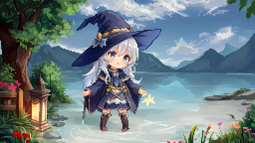
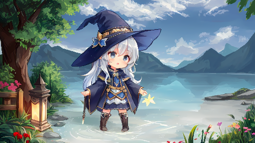
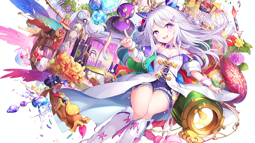
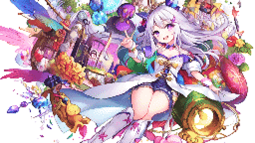
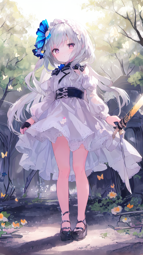
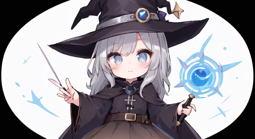
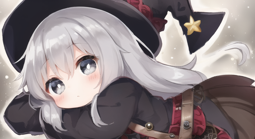

In [3]:
# @markdown <hr>

# @markdown ##Inferencing area!
# @markdown <hr>

# @markdown #🤔Inference Area


## User Inputs

model_path = r"E:\AI\miatiadev\miatia-tagger\models\wd-v1-4-convnextv2-tagger-v2\model.onnx" # @param{type:"string"}
img_dir = r"E:\AI\miatiadev\miatia-tagger\imgs\03_tagger" # @param{type:"string"}
preview_img_size = 255 # @param{type:"number"}

providers = ["CUDAExecutionProvider", "CPUExecutionProvider"]

## User Inputs End

import onnxruntime as rt
import numpy as np

## Definitions
import os
from icecream import ic
from Utils.inferences import plot_matrix_notebook, get_img_list, calc_embedding

# initialize
model = rt.InferenceSession(model_path, providers=providers)
if img_dir.endswith(("/", "\\")):
    img_dir = img_dir[:-1]

# get files
img_path_list, img_filename_list = get_img_list(img_dir)
embeddings = []
for i in range(len(img_path_list)):
    emb_txt = img_dir + "/" + f"{img_filename_list[i]}.npy"
    
    if os.path.exists(emb_txt):
      embedding = np.load(emb_txt)
    else:
      probs = calc_embedding(img_path_list[i], model)[0]
      embedding = probs[0]
      np.save(emb_txt, embedding)
    
    embeddings.append(embedding)

# print embeddings
for i in range(len(img_path_list)):
    ic(embeddings[i])
    ic(embeddings[i].shape[1])

#plot_matrix(embeddings, img_filename_list)

    ic(embedding[0].ndim)

plot_matrix_notebook(embeddings, sorted(img_path_list), preview_img_size, url_list)